In [1]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from profile_extraction import ProfileExtraction
from data_loader import UCSD_dataloader
from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

exp_suffix = "Mar2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
assert os.path.exists(exp_folder)

g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load data set
loader = UCSD_dataloader
loaded = loader(tstart=datetime(2019,1,1,0,0), tend=datetime(2020,1,1,0,0), delta=0.25, 
                bld="Hopkins", pv="Hopkins", ev="OSLER", pv_to_bld=0.5, ev_to_bld=0.2, Pmax=10)
data = loaded.get_data()

!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [bld] has [4] missing values
!!!!!!!!!! MISSING VALUES !!!!!!!!!! || [pv] has [4] missing values
!!!!!!!!!! EV SHORT DURATION !!!!!!!!!! || drop 81 sessions


In [4]:
tstart, tend = datetime(2019, 1, 1, 0, 0), datetime(2020, 1, 1, 0, 0)
pe = ProfileExtraction(data=data, tstart=tstart, tend=tend)

In [18]:
Ks = [5, 15]
# (alg, dist_metric, title)
algs = {"cluster": ("cluster", None, "K-means"),
        "US": ("sample", None, "Unif. sample"), 
        "IS": ("sample", "l2_center", "Imp. sample")}
res_dict = {k: {} for k in Ks}

ev_how_to = "unif"
ref, max_ref = None, None

for K in Ks:
    for a in algs.keys():
        if a == "cluster":
            alg, dist_metric = algs[a][:2]
        if a == "US":
            alg, dist_metric = "sample", None
        if a == "IS":
            alg, dist_metric = "sample", "l2_center"
        
        res = pe.rep_profile_extraction(alg=alg, K=K, dist_metric = dist_metric, 
                                        incl_ev=True, ev_how_to=ev_how_to)

        res_dict[K][a] = res

        if ref is None:
            ref = pe.cache["data_2D"].mean(axis=0).values
            max_ref = np.sqrt(((pe.cache["data_2D"] - ref.reshape(1,-1)) ** 2).mean(axis=1).values).max()

g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
e:\jerry ( 2021.1.20拷贝 )\Berkeley\Github Repo\Battery_sizing\src\profile_extraction.py:546: UserWarning: The sum of weights are 0.75. You may want to check.
  warnings.warn("The sum of weights are {:.2f}. You may want to check.".format(prob.sum()))
g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


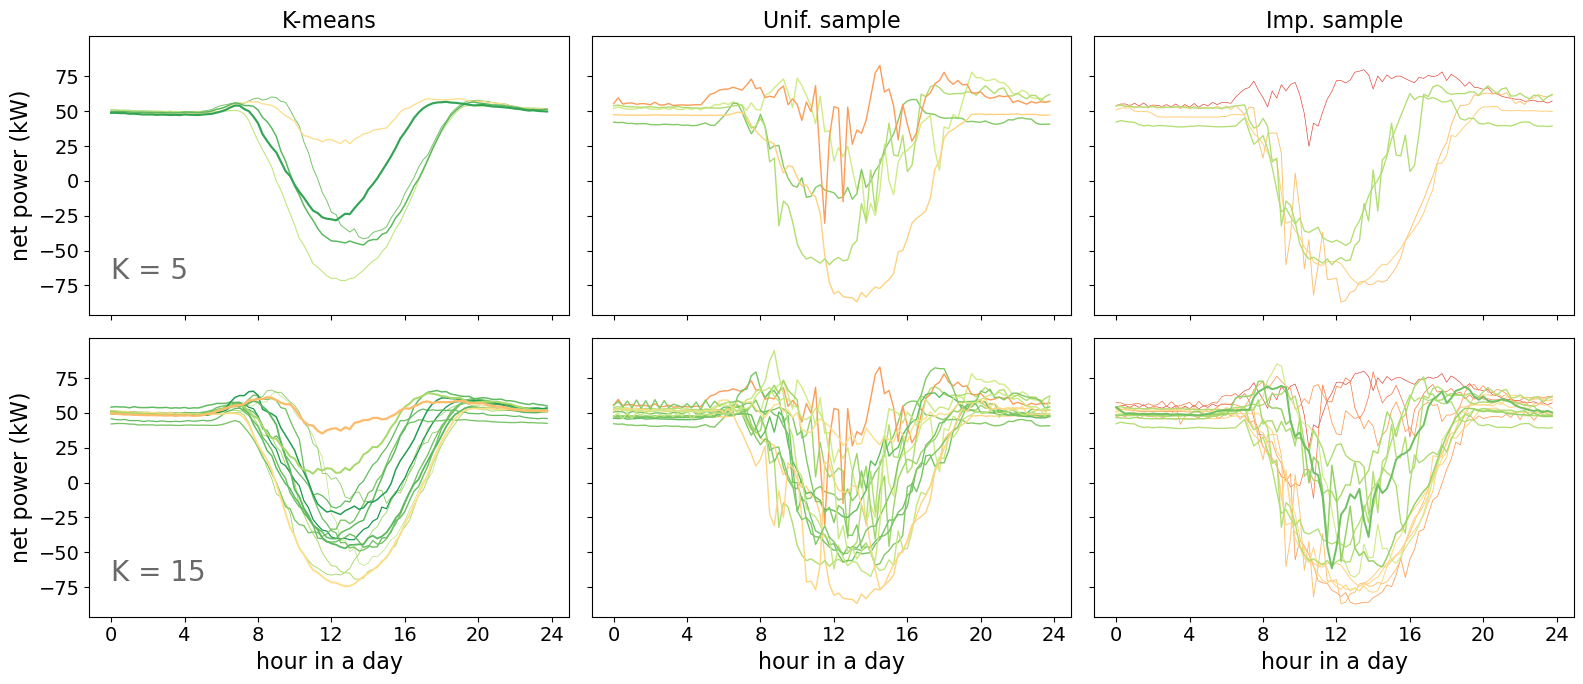

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(16,7), sharey=True, sharex=True)


for i in range(2):
    K = Ks[i]
    for j in range(3):
        alg = list(algs.keys())[j]
        res = res_dict[K][alg]
        ax = axs[i, j]

        rep_profile_visual(res.agg_power, res.prob, cmap_name="RdYlGn", ax=ax, ref=ref, max_ref=max_ref)
        
        if i == 0:
            ax.set_title(algs[alg][2])
            ax.set_xticklabels([])
        else:
            ax.set_xticks(np.arange(0, 25, 4))
            ax.set_xticklabels(np.arange(0, 25, 4))
            ax.set_xlabel("hour in a day")
        
        if j == 0:
            ax.set_ylabel("net power (kW)")
            ax.set_yticks(np.arange(-75,76,25))

            ax.text(0, -75, f"K = {K}", fontsize=20, ha="left", va="bottom", color="dimgrey")


plt.tight_layout()
plt.savefig("358-fig3-profile_visual.png", dpi=300, facecolor="w", bbox_inches="tight")